In [1]:
import os

import pandas as pd
import numpy as np

import torch
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
from torchmetrics import Accuracy

import pytorch_lightning as pl
from vit_pytorch.vit_1d import ViT

NUM_WORKERS = int(os.cpu_count() // 4)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
torch.set_float32_matmul_precision('medium')

Using cuda device


#### Import training/testing data

In [2]:
train_df = pd.read_pickle('train.pkl.gz').sample(frac=1, random_state=1)
test_df = pd.read_pickle('test.pkl.gz').sample(frac=1, random_state=2)

In [3]:
train_df.head(4)

,Data,Label
674,"[[1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...",674
1699,"[[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1699
1282,"[[2, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,...",1282
1315,"[[0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1315


#### Each data is a (250, 128) numpy array per label

In [4]:
# Convert pandas to numpy array

data_array_train = np.stack(train_df['Data'])
label_array_train = np.stack(train_df['Label'])


data_array_test = np.stack(test_df['Data'])
label_array_test = np.stack(test_df['Label'])


data_array_test.shape, label_array_test.shape, \
data_array_train.shape, label_array_train.shape

((2000, 250, 128), (2000,), (2000, 250, 128), (2000,))

#### Put data and labels as a torch dataset

In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_array, label_array):
        self.data = torch.from_numpy(data_array).float()
        self.labels = label_array

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

training_data = Dataset(data_array_train, label_array_train)
testing_data = Dataset(data_array_test, label_array_test)

#### Using LightningDataModule to train/test etc later on. We will also split training into 80/20 for validation.

In [6]:

class DataModule(pl.LightningDataModule):
    def __init__(self, batch_size=256):
        super().__init__()
        self.batch_size = batch_size

    def setup(self, stage: str):
        self.test = testing_data
        full = training_data
        self.train, self.val = random_split(
            full, [0.8, 0.2], generator=torch.Generator().manual_seed(12345)
        )

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, shuffle=True, num_workers=NUM_WORKERS)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size, shuffle=False, num_workers=NUM_WORKERS)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size, shuffle=False, num_workers=NUM_WORKERS)


#### The trainer module for transformer 

In [7]:
NUM_CLASSES = len(set(label_array_train))

class MyLitModel(pl.LightningModule):
    def __init__(self, lr=0.05):
        super().__init__()
        self.save_hyperparameters()
        self.model = ViT(
                        seq_len = 128, # this comes from shape of input data
                        patch_size = 4,
                        num_classes = NUM_CLASSES,
                        dim = 1024,
                        depth = 6,
                        heads = 16,
                        mlp_dim = 2048, 
                        channels=250, # this comes from shape of input data
                    )
        self.train_accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
        self.loss_fn = nn.CrossEntropyLoss()
    
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log("train_loss", loss, prog_bar=True,)
        acc = self.train_accuracy(logits, y)
        self.log("train_accuracy", acc, prog_bar=True,)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log("val_loss", loss, prog_bar=True, )
        acc = self.val_accuracy(logits, y)
        self.log("val_accuracy", acc, prog_bar=True,)
        
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log("test_loss", loss, prog_bar=True,)
        acc = self.test_accuracy(logits, y)
        self.log("test_accuracy", acc, prog_bar=True,)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.hparams.lr, momentum=0.9)
        return optimizer

#### Train the model and log intermediate results

In [10]:
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping

logger = CSVLogger("logs", name="ViT")

model = MyLitModel(lr=0.05)

data = DataModule()
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="auto",
    devices="auto",
    logger=logger,
    callbacks=EarlyStopping('val_loss', patience=5),
    log_every_n_steps=4
)

trainer.fit(model, datamodule=data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/ViT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params
------------------------------------------------------
0 | model          | ViT                | 53.5 M
1 | train_accuracy | MulticlassAccuracy | 0     
2 | val_accuracy   | MulticlassAccuracy | 0     
3 | test_accuracy  | MulticlassAccuracy | 0     
4 | loss_fn        | CrossEntropyLoss   | 0     
------------------------------------------------------
53.5 M    Trainable params
0         Non-trainable params
53.5 M    Total params
213.987   Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

#### Test accuracy

In [11]:
trainer.test(model, datamodule=data)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.6230000257492065
        test_loss            3.817396640777588
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 3.817396640777588, 'test_accuracy': 0.6230000257492065}]

#### Some plottings

In [12]:
logs = pd.read_csv('logs/ViT/version_0/metrics.csv')
logs.head(2)

,epoch,step,test_accuracy,test_loss,train_accuracy,train_loss,val_accuracy,val_loss
0,0,3,NaN,NaN,0.0,7.932872,NaN,NaN
1,0,6,NaN,NaN,NaN,NaN,0.0,8.36457


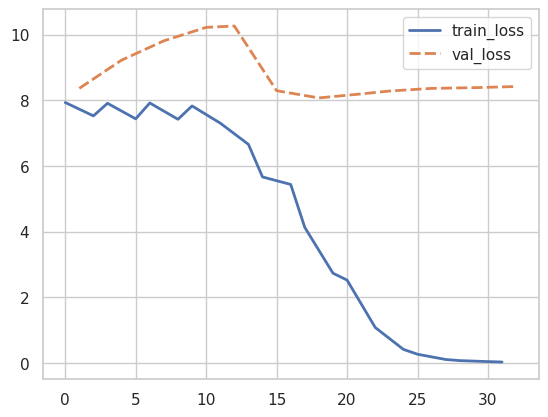

In [13]:
import seaborn as sns
sns.set_theme(style='whitegrid', palette='deep', font_scale=1.,)

sns.lineplot(data=logs[['train_loss', 'val_loss']], lw=2);

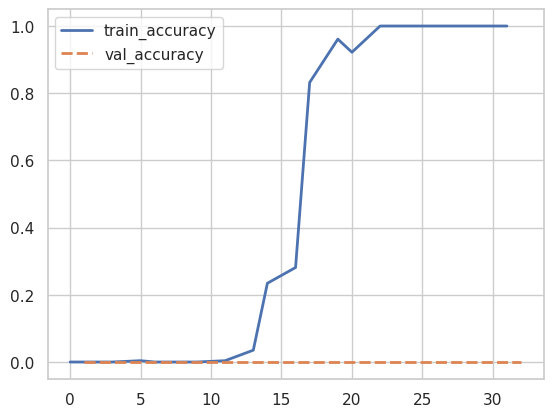

In [14]:
sns.lineplot(data=logs[['train_accuracy', 'val_accuracy']], lw=2);

#### The trained model and hyperparameters are inside logs/ViT/ ... directory. 

#### This is how to load the model to do predictions on some other data later on

In [34]:
# Load the trainer and model
loaded_trainer = pl.Trainer(default_root_dir="logs/ViT/version_0/")
loaded_model = MyLitModel.load_from_checkpoint("logs/ViT/version_0/checkpoints/epoch=11-step=84.ckpt")

# disable randomness, dropout, etc...
loaded_model.eval()


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


MyLitModel(
  (model): ViT(
    (to_patch_embedding): Sequential(
      (0): Rearrange('b c (n p) -> b n (p c)', p=4)
      (1): LayerNorm((1000,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=1000, out_features=1024, bias=True)
      (3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
    (dropout): Dropout(p=0.0, inplace=False)
    (transformer): Transformer(
      (layers): ModuleList(
        (0-5): 6 x ModuleList(
          (0): Attention(
            (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.0, inplace=False)
            (to_qkv): Linear(in_features=1024, out_features=3072, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=1024, out_features=1024, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
          (1): FeedForward(
            (net): Sequential(
              (0): LayerNorm((

In [35]:
# load the data to to predictions on

pred_df = pd.read_pickle('pred.pkl.gz')
pred_df.head(2)

,Data,Label
0,"[[0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,...",0
1,"[[1, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0,...",1


In [36]:
# Make a numpy array of Data
data_array_pred = np.stack(pred_df['Data'])
data_array_pred.shape

(2000, 250, 128)

In [37]:
# Make a datamodule for prediction

class DataModulePredict(pl.LightningDataModule):
    def __init__(self, batch_size=256):
        super().__init__()
        self.batch_size = batch_size

    def setup(self, stage: str):
        self.predict = torch.from_numpy(data_array_pred).float() 

    def predict_dataloader(self):
        return DataLoader(self.predict, batch_size=self.batch_size, shuffle=False, num_workers=NUM_WORKERS)


In [38]:
# Run the predictions on the data using the loaded model and loaded trainer
preds = loaded_trainer.predict(loaded_model, datamodule=DataModulePredict())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [40]:
# Predictions are logits. Use argmax to find the actual label
# For eg for the first batch of predictions:

preds[0].argmax(dim=1)

tensor([1745,    1,  676,  344,    4, 1248, 1593,    7,  819,  757,   10,   11,
        1394,   13,   14,   15, 1548,   17,   18,   19,   20,   21,   22,   23,
          24,   25,   26,   27,  918,   29,  740, 1428,  220,   33, 1450,   57,
          36,   37,   38,   39,   40,   41,   42,   43,  815,   45,   46, 1668,
          48,   49,  122,   51,   52,   53,   54, 1654, 1062,   57,   58,   59,
         198,   61, 1273,   63, 1985,   65,   66,   67,   68, 1232,   70, 1285,
          72,  171,   74,   75,   76,   77,   65, 1118,   80,   81,   82,   83,
          84,  837,   86,   87,   88, 1091,  280, 1111, 1315,   93,  965,  628,
          96,   97,   98,   99,  100,  101,  102, 1917,  104,  105,  106,  107,
         108,  109,  110,   93, 1385,  113,  903,  115,   65,  117,  118,  119,
         120, 1154,  122,  724,  124, 1024, 1535,  127,  128,  129,  130, 1536,
         132,  216,  134,  135,  963,  324, 1560,  139,  140, 1069, 1783,  289,
         144,  324,  146, 1971,  951,  1

In [41]:
# Can also find the accuracy in this new data
# For the first batch it is like 
preds_, targets = preds[0].argmax(dim=1), np.stack(pred_df['Label'])[:256]


accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
accuracy(preds_, torch.from_numpy(targets))

tensor(0.6094)